# DeepONet

## Linear elastic cantilever beam under displacement boundary conditions

Governing equation: $-\nabla\cdot \sigma = 0$.

<img src="https://github.com/DesignSafe-Training/deeponet/blob/main/Schematic.png?raw=true" width=1150 height=550 />

### Install packages

In [1]:
!pip install jax[cuda] numpy scikit-learn flax scipy termcolor tqdm matplotlib seaborn --user


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Fetch geometry and trained model data

In [ ]:
!mkdir -p deeponet_results
!wget https://github.com/DesignSafe-Training/deeponet/raw/refs/heads/main/model_params_best.pkl -P deeponet_results/

In [ ]:
!wget https://github.com/DesignSafe-Training/deeponet/raw/refs/heads/main/cantilever_beam_deflection.mat

In [ ]:
import jax.numpy as jnp
import numpy.random as npr
from jax import jit, grad, vmap
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
from functools import partial
from jax import jacfwd, jacrev
import jax.nn as jnn
import math
from jax import random
import jax
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from flax import linen as nn
import sklearn.metrics
from scipy.interpolate import griddata
from matplotlib.colors import SymLogNorm
from tqdm import tqdm

import os
import time
from termcolor import colored
from scipy.io import loadmat
import scipy.io as io
import pickle

import sys
sys.path.append("../..")

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 9})
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

# Check where gpu is enable or not
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [18]:
save = True
resultdir = os.path.join(os.getcwd(), 'deeponet_results')
if save == True:
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

### Data 

In [19]:
# Load the data
data = loadmat('./cantilever_beam_deflection.mat') # Load the .mat file
print("Shape of loading matrix (Input Function):", data['loading'].shape) # Input to deeponet - varying loading conditions
print("Shape of Displacement-X matrix (Output Function):", data['disp_x'].shape) # Output from deeponet - The corresponding deflection in X-direction
print("Shape of Displacement-Y matrix (Output Function):", data['disp_y'].shape) # Output from deeponet - The corresponding deflection in Y-direction

# Convert NumPy arrays to tensors
inputs = jnp.array(data['loading'])
sensor_loc = jnp.array(data['sensor_loc_loading'])
outputs_x = jnp.array(data['disp_x'])
outputs_y = jnp.array(data['disp_y'])
grid_x = data['coord_x'].T
grid_y = data['coord_y'].T
grid = jnp.concatenate([grid_x, grid_y], axis=1, dtype=None)
print("Shape of grid for the cantilever beam:", grid.shape) # (n,2)

num_train = 800
num_test = 200
# Split the data into training (800) and testing (200) samples
inputs_train, inputs_test, outputs_x_train, outputs_x_test, outputs_y_train, outputs_y_test = train_test_split(inputs, outputs_x, outputs_y, test_size=200, random_state=0)
print("Shape of loading matrix used for training:", inputs_train.shape)
print("Shape of x-displacement matrix corresponding to the training loads:", outputs_x_train.shape)
print("Shape of y-displacement matrix corresponding to the training loads:", outputs_y_train.shape)
print("Shape of loading matrix used for testing:", inputs_test.shape)
print("Shape of x-displacement matrix corresponding to the testing loads:", outputs_x_test.shape)
print("Shape of y-displacement matrix corresponding to the testing loads:", outputs_y_test.shape)
print('#'*100)

Shape of loading matrix (Input Function): (1000, 100)
Shape of Displacement-X matrix (Output Function): (1000, 1314)
Shape of Displacement-Y matrix (Output Function): (1000, 1314)
Shape of grid for the cantilever beam: (1314, 2)
Shape of loading matrix used for training: (800, 100)
Shape of x-displacement matrix corresponding to the training loads: (800, 1314)
Shape of y-displacement matrix corresponding to the training loads: (800, 1314)
Shape of loading matrix used for testing: (200, 100)
Shape of x-displacement matrix corresponding to the testing loads: (200, 1314)
Shape of y-displacement matrix corresponding to the testing loads: (200, 1314)
####################################################################################################


### Define a Neural Network

In [20]:
# network parameters.
p = 100 # Number of output neurons in both the branch and trunk net.
num_sensor = inputs_train.shape[1]
input_neurons_branch = num_sensor
input_neurons_trunk = grid.shape[1]
layer_sizes_b = [input_neurons_branch] + [100]*6 + [2*p]
layer_sizes_t = [input_neurons_trunk] + [100]*6 + [2*p]

bs = 450 # batch size
n_epochs = 200000

In [21]:
# Initialize the Glorot (Xavier) normal distribution for weight initialization
initializer = jax.nn.initializers.glorot_normal()

def init_glorot_params(layer_sizes, key = random.PRNGKey(0)):
    """
    Initialize the parameters of the neural network using Glorot (Xavier) initialization.

    Args:
    layer_sizes (list): List of integers representing the size of each layer.
    key (PRNGKey): Random number generator key for reproducibility.

    Returns:
    list: List of tuples, each containing weights and biases for a layer.
    """
    return [(initializer(key, (m, n), jnp.float32), jnp.zeros(n))
            for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

params_branch = init_glorot_params(layer_sizes=layer_sizes_b)
params_trunk = init_glorot_params(layer_sizes=layer_sizes_t)
params= (params_branch, params_trunk)

# Initialize the Adam optimizer
opt_init, opt_update, get_params = adam(step_size=1e-3, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(params)

In [22]:
def BranchNet(params, x):
    """
    Implement the branch network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (array): Input to the branch network.

    Returns:
    array: Output of the branch network.
    """
    def single_forward(params, x):
        for w, b in params:
            outputs = jnp.dot(x, w) + b
            x = jnn.silu(outputs)
        return outputs

    return vmap(partial(single_forward, params))(x)

def TrunkNet(params, x, y):
    """
    Implement the trunk network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (float): First input to the trunk network.
    t (float): Second input to the trunk network.

    Returns:
    array: Output of the trunk network.
    """
    inputs = jnp.array([x, y])
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b
        inputs = jnn.silu(outputs)
    return outputs

@jit
def DeepONet(params, branch_inputs, trunk_inputs):
    """
    Implement the complete DeepONet architecture.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.

    Returns:
    array: Output of the DeepONet.
    """
    params_branch, params_trunk = params
    branch_outputs = lambda x: BranchNet(params_branch, x)
    b_out = branch_outputs(branch_inputs)
    trunk_output = lambda x, y: TrunkNet(params_trunk, x, y)
    t_out = vmap(trunk_output)(trunk_inputs[:,0],trunk_inputs[:,1])
    results_x = jnp.einsum('ik, lk -> il',b_out[:,0:p], t_out[:,0:p])
    results_y = jnp.einsum('ik, lk -> il',b_out[:,p:2*p], t_out[:,p:2*p])
    return results_x, results_y

In [23]:
def objective(params, branch_inputs, trunk_inputs, target_values_x, target_values_y):
    """
    Define the objective function (loss function) for training.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values to compare against.

    Returns:
    float: Mean squared error loss.
    """

    predictions_x, predictions_y = DeepONet(params, branch_inputs, trunk_inputs)
    loss_mse = jnp.mean((predictions_x - target_values_x)**2) + jnp.mean((predictions_y - target_values_y)**2)
    return loss_mse


# Adam optimizer
@jit
def network_update(params, branch_inputs, trunk_inputs, target_values_x, target_values_y, opt_state):
    """
    Compute the gradient for a batch and update the parameters.

    Args:
    params (tuple): Current network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values.
    opt_state: Current state of the optimizer.

    Returns:
    tuple: Updated parameters, updated optimizer state, and current loss value.
    """
    value, grads = value_and_grad(objective)(params, branch_inputs, trunk_inputs, target_values_x, target_values_y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [ ]:
def save_model_params(params, resultdir, filename='model_params.pkl'):
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

    save_path = os.path.join(resultdir, filename)
    with open(save_path, 'wb') as f:
        pickle.dump(params, f)

def load_model_params(resultdir, filename='model_params.pkl'):
    load_path = os.path.join(resultdir, filename)
    with open(load_path, 'rb') as f:
        params = pickle.load(f)
    return params

# Saving
if save:
    save_model_params(params, resultdir)

# Loading (uncomment when needed)
# model_params = load_model_params(resultdir)

### Training

------------- START TRAINING -------------
Saved initial model at iteration 0
New best model saved at iteration 0 with test MSE: 0.0390862
Iteration:   0, Train loss: 0.0390862, Test loss: 0.0390862, Best test loss: 0.0390862, Time: 2.12
New best model saved at iteration 1000 with test MSE: 0.0027250
Iteration: 1000, Train loss: 0.0027250, Test loss: 0.0027250, Best test loss: 0.0027250, Time: 9.67
New best model saved at iteration 2000 with test MSE: 0.0007205
Iteration: 2000, Train loss: 0.0007205, Test loss: 0.0007205, Best test loss: 0.0007205, Time: 16.55
New best model saved at iteration 3000 with test MSE: 0.0003108
Iteration: 3000, Train loss: 0.0003108, Test loss: 0.0003108, Best test loss: 0.0003108, Time: 23.31
New best model saved at iteration 4000 with test MSE: 0.0002083
Iteration: 4000, Train loss: 0.0002083, Test loss: 0.0002083, Best test loss: 0.0002083, Time: 30.40
New best model saved at iteration 5000 with test MSE: 0.0001633
Iteration: 5000, Train loss: 0.0001633,

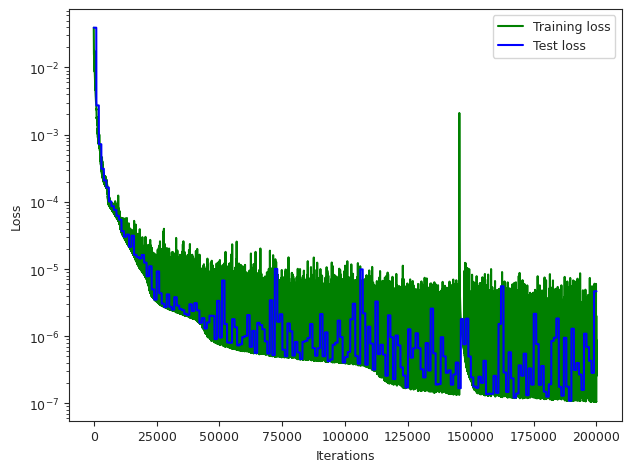

Time (sec) to complete:
1461.7830984592438


<Figure size 640x480 with 0 Axes>

In [ ]:
num_samples = len(inputs_train)

# Training of DeepONet
start = time.time()  # start time of training
best_test_mse = float('inf')  # Initialize with infinity

print("------------- START TRAINING -------------")
# Save initial model at 0th iteration

save_model_params(params, resultdir, filename='model_params_best.pkl')
print("Saved initial model at iteration 0")
iteration_list, loss_list, test_loss_list = [], [], []

# Create tqdm progress bar
pbar = tqdm(range(n_epochs), desc='Training', ncols=175)

for iteration in pbar:
    # Shuffle and batch data
    indices = jax.random.permutation(jax.random.PRNGKey(0), num_samples)
    batch_index = indices[0:bs]
    inputs_train_shuffled = inputs_train[batch_index]
    outputs_x_train_shuffled = outputs_x_train[batch_index]
    outputs_y_train_shuffled = outputs_y_train[batch_index]
    # Set target values
    target_values_x = outputs_x_train_shuffled
    target_values_y = outputs_y_train_shuffled
    branch_inputs = inputs_train_shuffled
    trunk_inputs = grid
    # Update network
    params, opt_state, value = network_update(
        params, branch_inputs, trunk_inputs,
        target_values_x, target_values_y, opt_state
    )
    # Evaluate and save model every 1000 iterations
    if iteration % 1000 == 0:
        predictions_x, predictions_y = DeepONet(params, branch_inputs, trunk_inputs)
        test_mse = jnp.mean((predictions_x - target_values_x)**2) + \
                   jnp.mean((predictions_y - target_values_y)**2)
        current_loss = objective(params, branch_inputs, trunk_inputs,
                               target_values_x, target_values_y)
        # Update best model if needed
        if test_mse < best_test_mse:
            best_test_mse = test_mse
            save_model_params(params, resultdir, filename='model_params_best.pkl')
            desc = f'Training (New Best: {test_mse:.2e} @ iter {iteration})'
            pbar.set_description(desc)
        # Calculate training time
        finish = time.time() - start
        # Update progress bar description with metrics
        pbar.set_postfix({
            'Train Loss': f'{current_loss:.2e}',
            'Test Loss': f'{test_mse:.2e}',
            'Best Test': f'{best_test_mse:.2e}',
            'Time': f'{finish:.2e}s'
        })

    # Store metrics for plotting
    iteration_list.append(iteration)
    loss_list.append(objective(params, branch_inputs, trunk_inputs, target_values_x, target_values_y))
    test_loss_list.append(test_mse)

if save:
    np.save(os.path.join(resultdir, 'iteration_list.npy'), np.asarray(iteration_list))
    np.save(os.path.join(resultdir, 'loss_list.npy'), np.asarray(loss_list))
    np.save(os.path.join(resultdir, 'test_loss_list.npy'), np.asarray(test_loss_list))

# Plotting code remains the same
plt.figure()
plt.plot(iteration_list, loss_list, '-g', label='Training loss')
plt.plot(iteration_list, test_loss_list, '-b', label='Test loss')
plt.yscale("log")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
if save:
    plt.savefig(os.path.join(resultdir, 'loss_plot.pdf'))
# end timer
finish = time.time() - start
print("Time (sec) to complete:\n" + str(finish))

In [ ]:
# Load the best model parameters
best_params = load_model_params(resultdir, filename='model_params_best.pkl')

# Predictions
mse_list_x = []
mse_list_y = []

branch_inputs = inputs_test
trunk_inputs = grid
prediction_x, prediction_y = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval) = (1, nt*nz)

save_dict = {'Loading': inputs_test, 'pred_x': prediction_x, 'pred_y': prediction_y,\
             'target_x': outputs_x_test, 'target_y': outputs_y_test}

io.savemat(resultdir+'/deeponet_prediction.mat', save_dict)
print("Saved the prediction for all the test samples")

Loaded best model parameters
Saved the prediction for all the test samples


TEST SAMPLE 10
Rel. L2 Error (X-Displacement) = 0.0047, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0018, R2 score (Y-Displacement) = 1.0


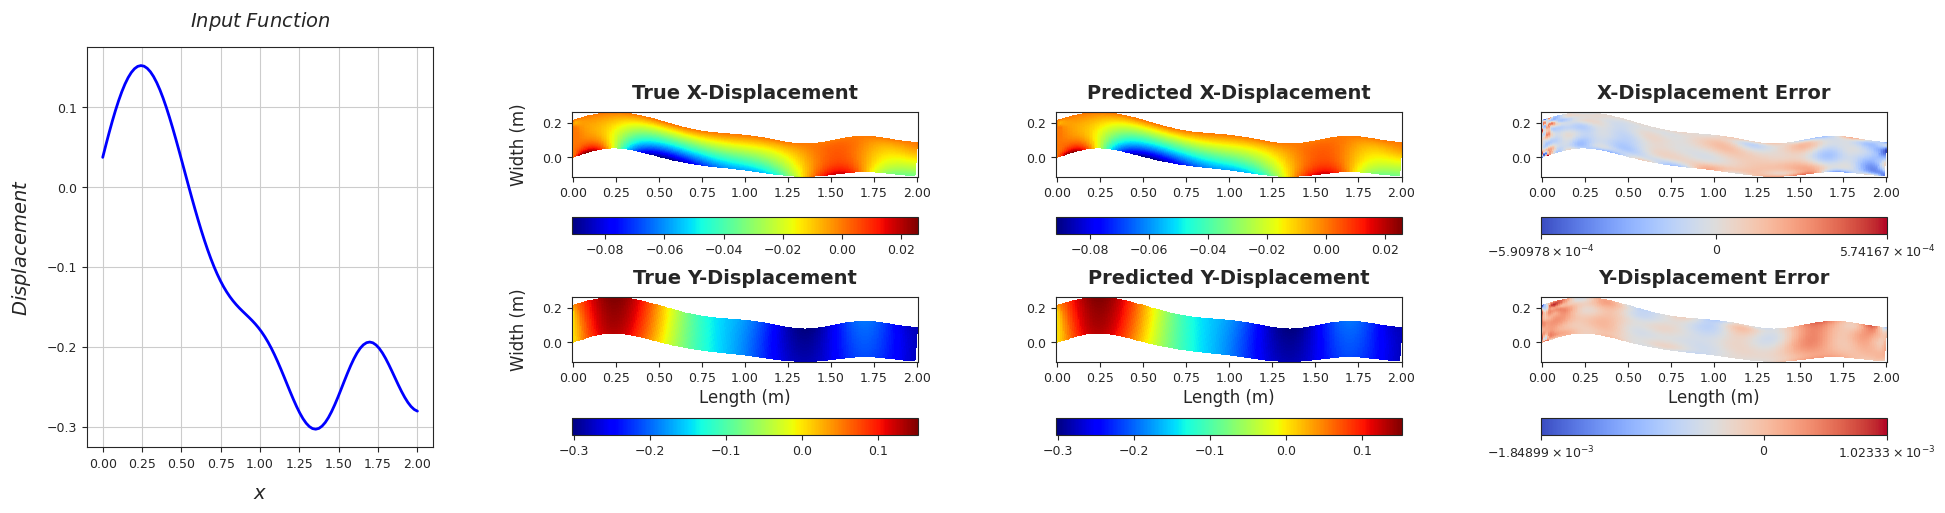

######################################################################################################################################################################################################################################
TEST SAMPLE 20
Rel. L2 Error (X-Displacement) = 0.0052, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0029, R2 score (Y-Displacement) = 1.0


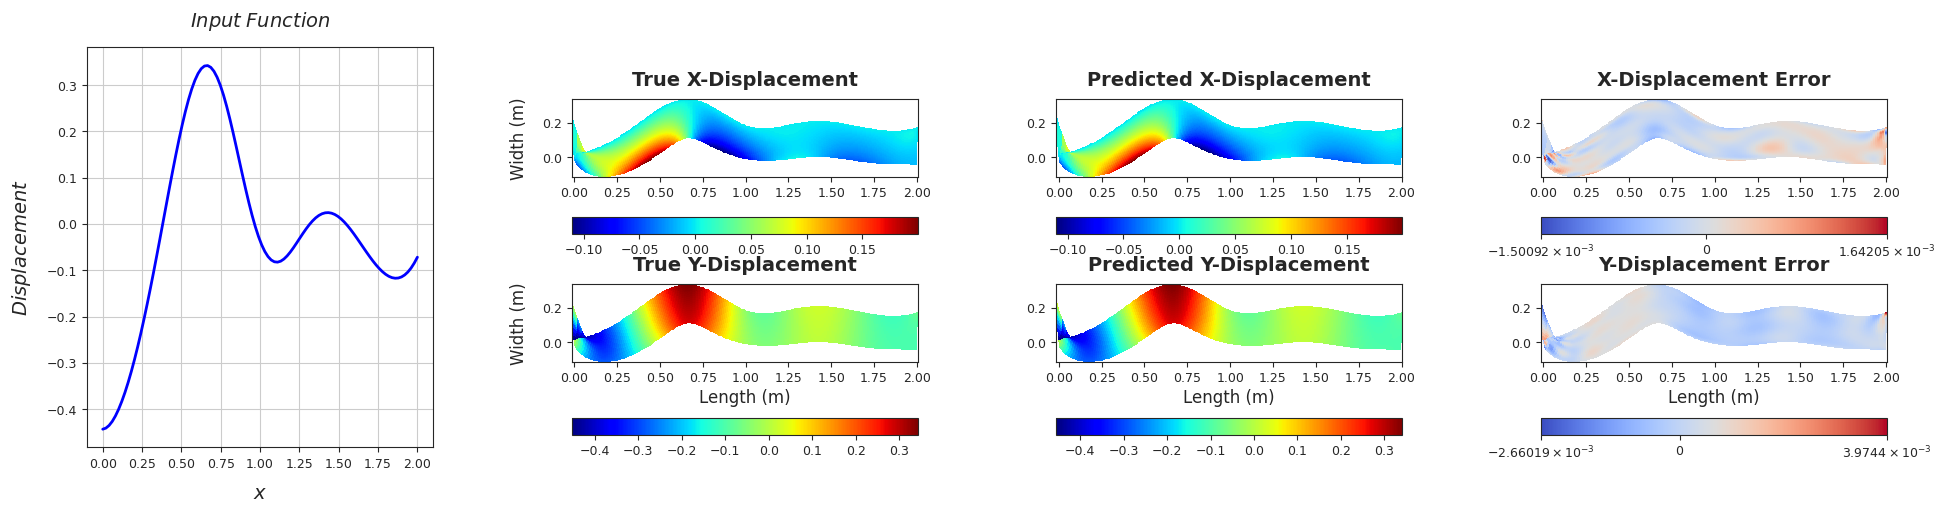

######################################################################################################################################################################################################################################
TEST SAMPLE 30
Rel. L2 Error (X-Displacement) = 0.0048, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0037, R2 score (Y-Displacement) = 1.0


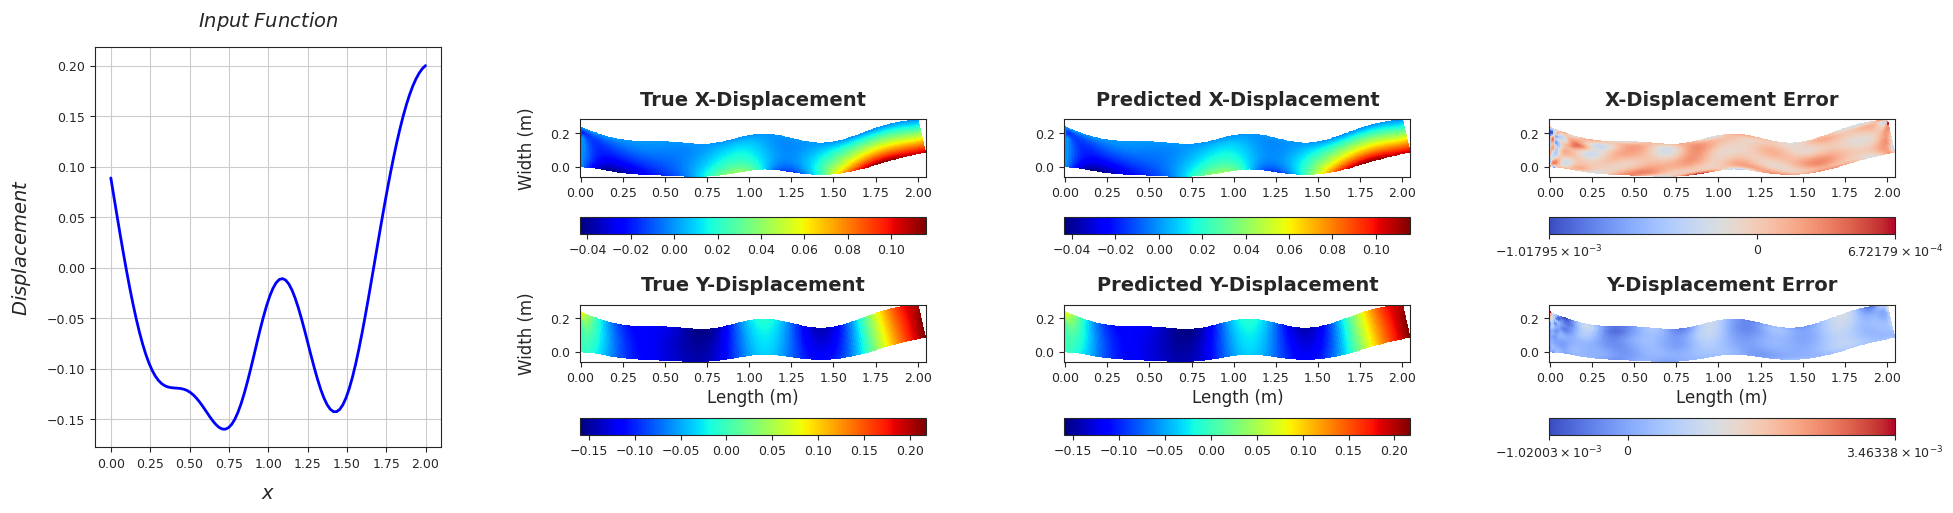

######################################################################################################################################################################################################################################
TEST SAMPLE 40
Rel. L2 Error (X-Displacement) = 0.0051, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0039, R2 score (Y-Displacement) = 1.0


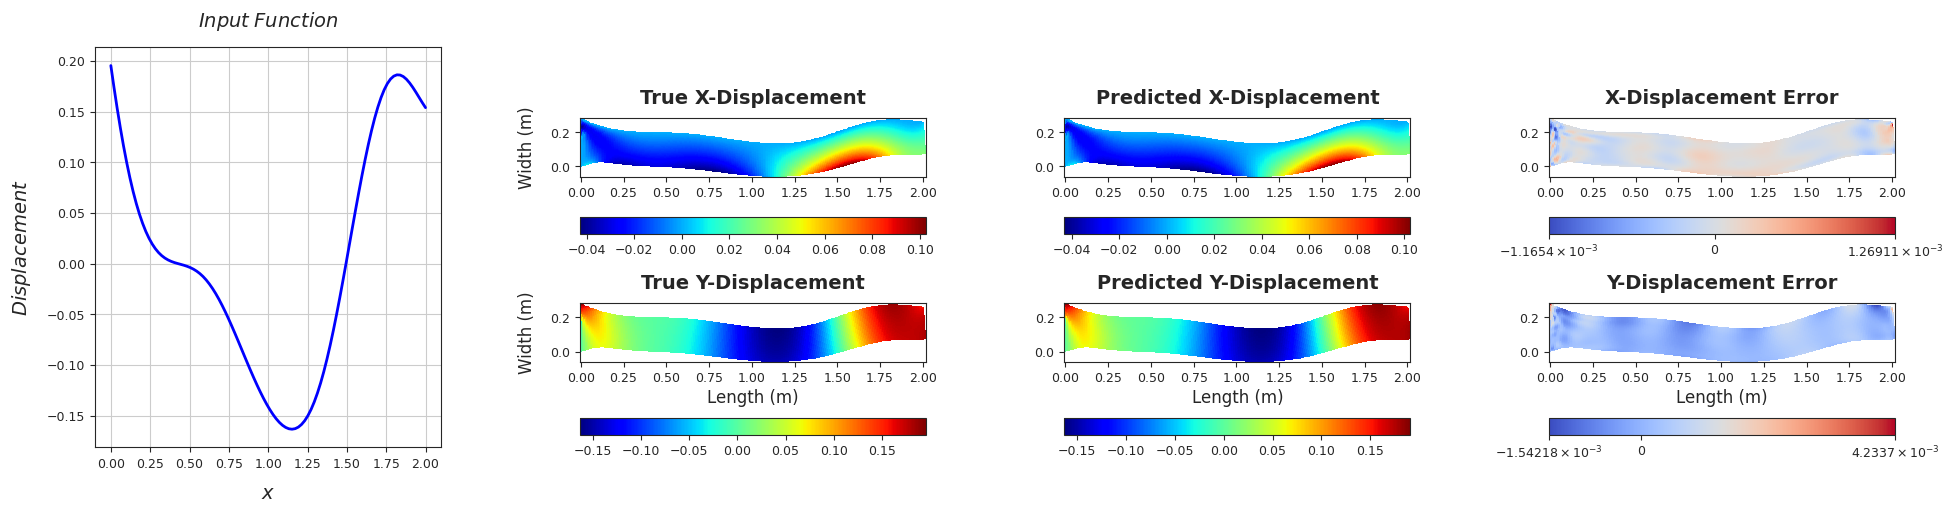

######################################################################################################################################################################################################################################
TEST SAMPLE 50
Rel. L2 Error (X-Displacement) = 0.0054, R2 score (X-Displacement) = 0.9999
Rel. L2 Error (Y-Displacement) = 0.0026, R2 score (Y-Displacement) = 1.0


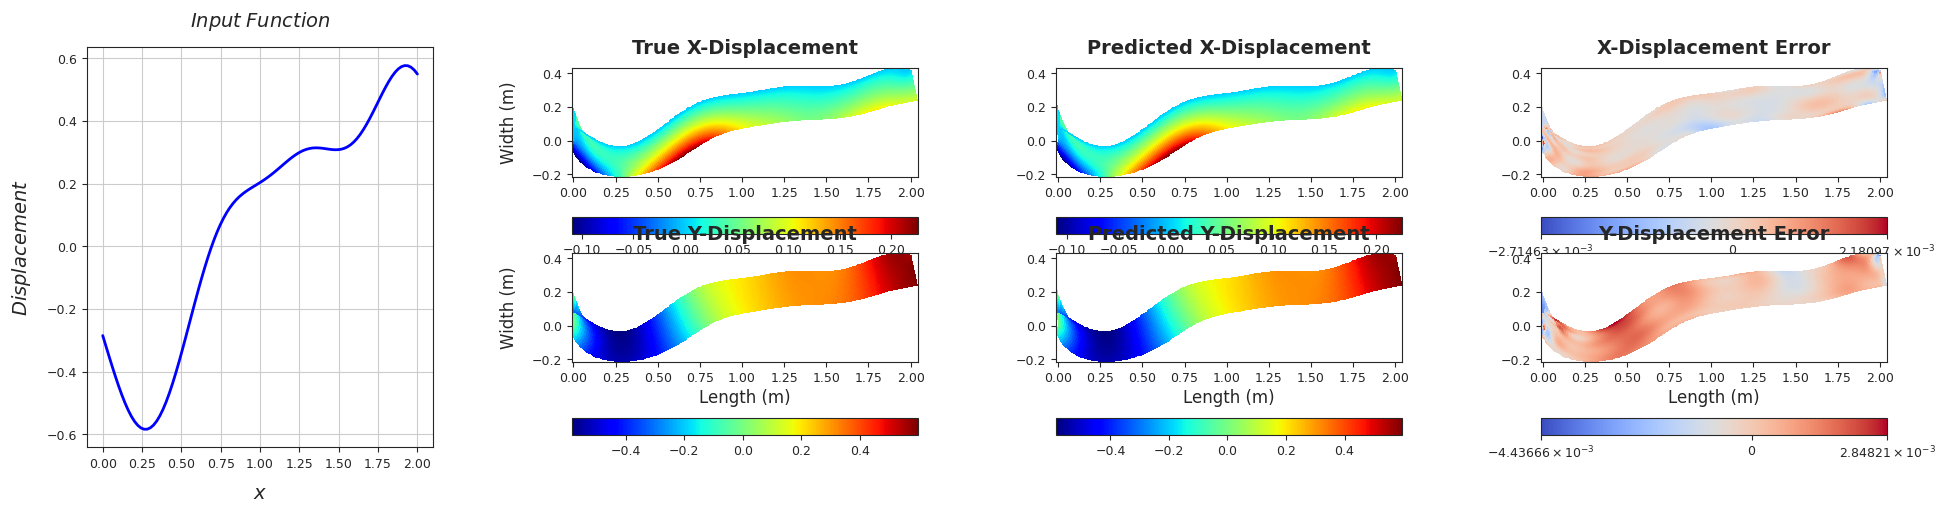

######################################################################################################################################################################################################################################
TEST SAMPLE 60
Rel. L2 Error (X-Displacement) = 0.0102, R2 score (X-Displacement) = 0.9999
Rel. L2 Error (Y-Displacement) = 0.0024, R2 score (Y-Displacement) = 0.9999


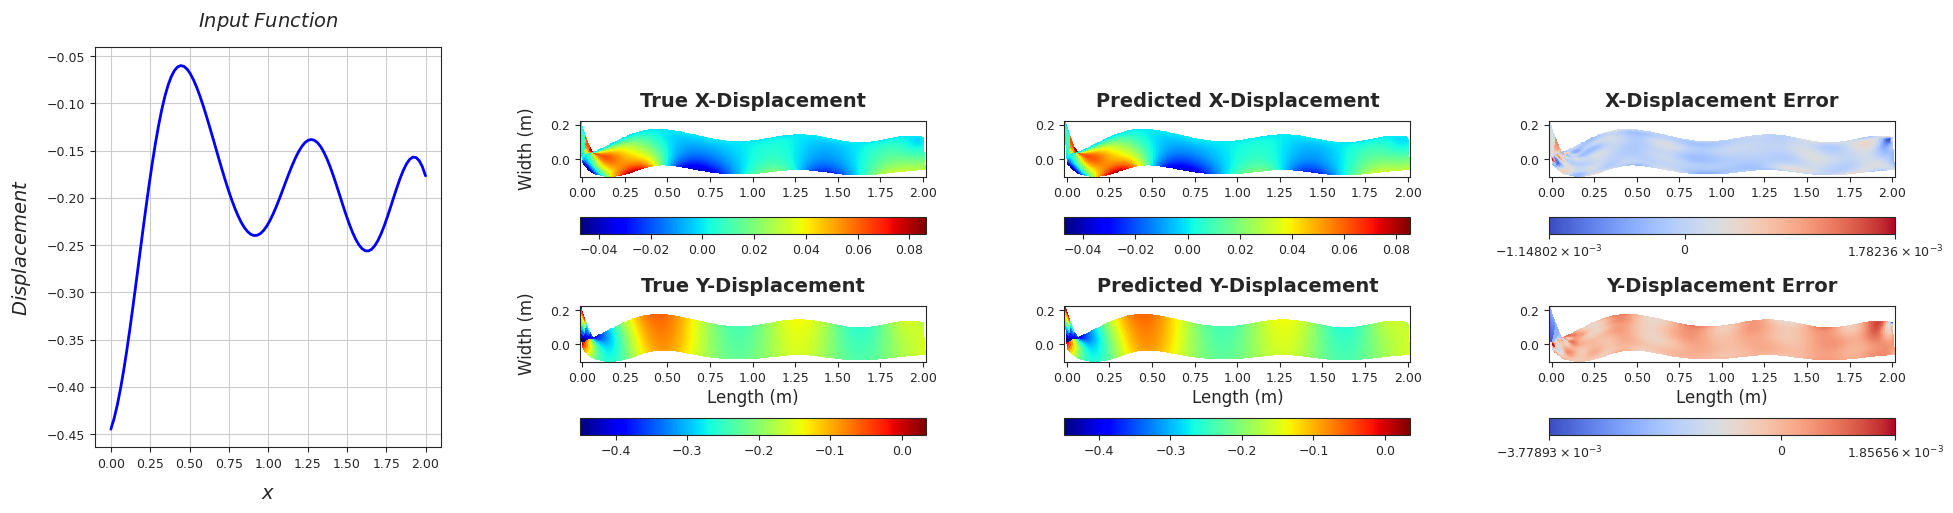

######################################################################################################################################################################################################################################
TEST SAMPLE 70
Rel. L2 Error (X-Displacement) = 0.0067, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0032, R2 score (Y-Displacement) = 1.0


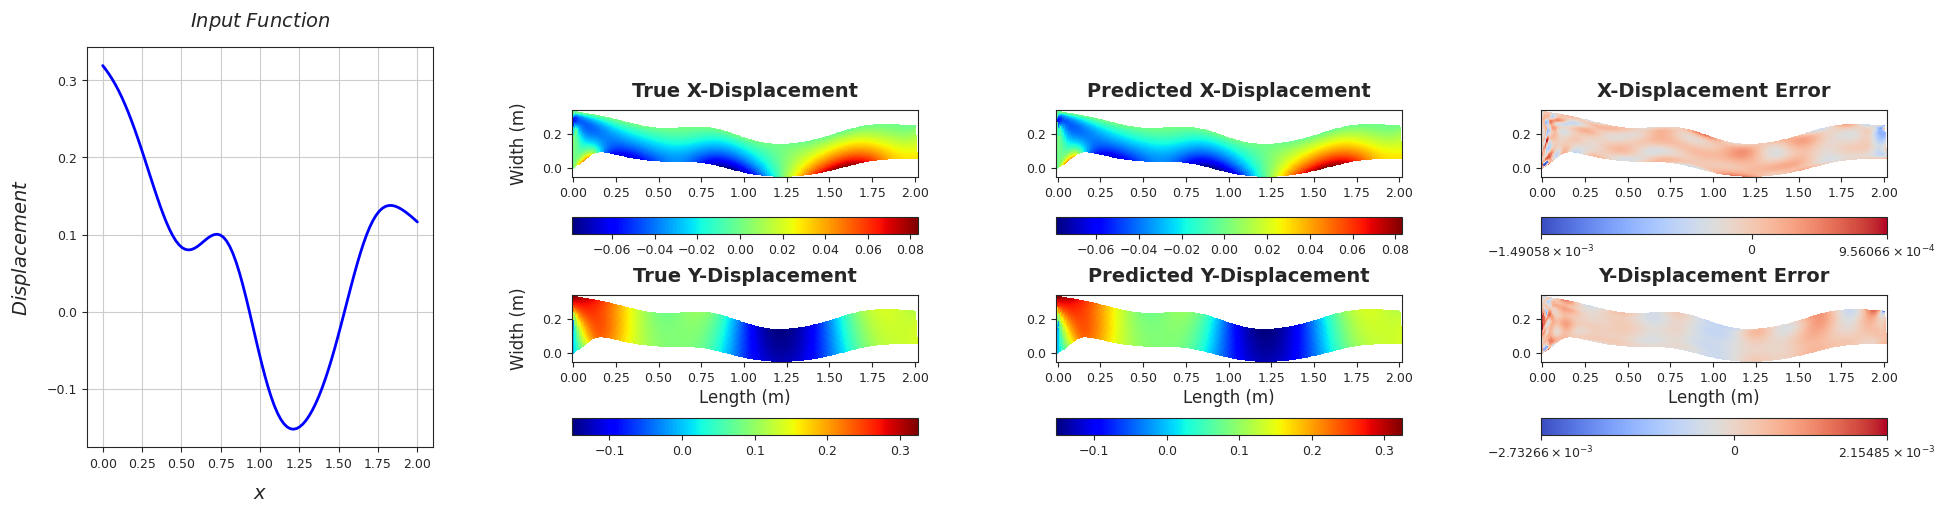

######################################################################################################################################################################################################################################
TEST SAMPLE 80
Rel. L2 Error (X-Displacement) = 0.0048, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0023, R2 score (Y-Displacement) = 1.0


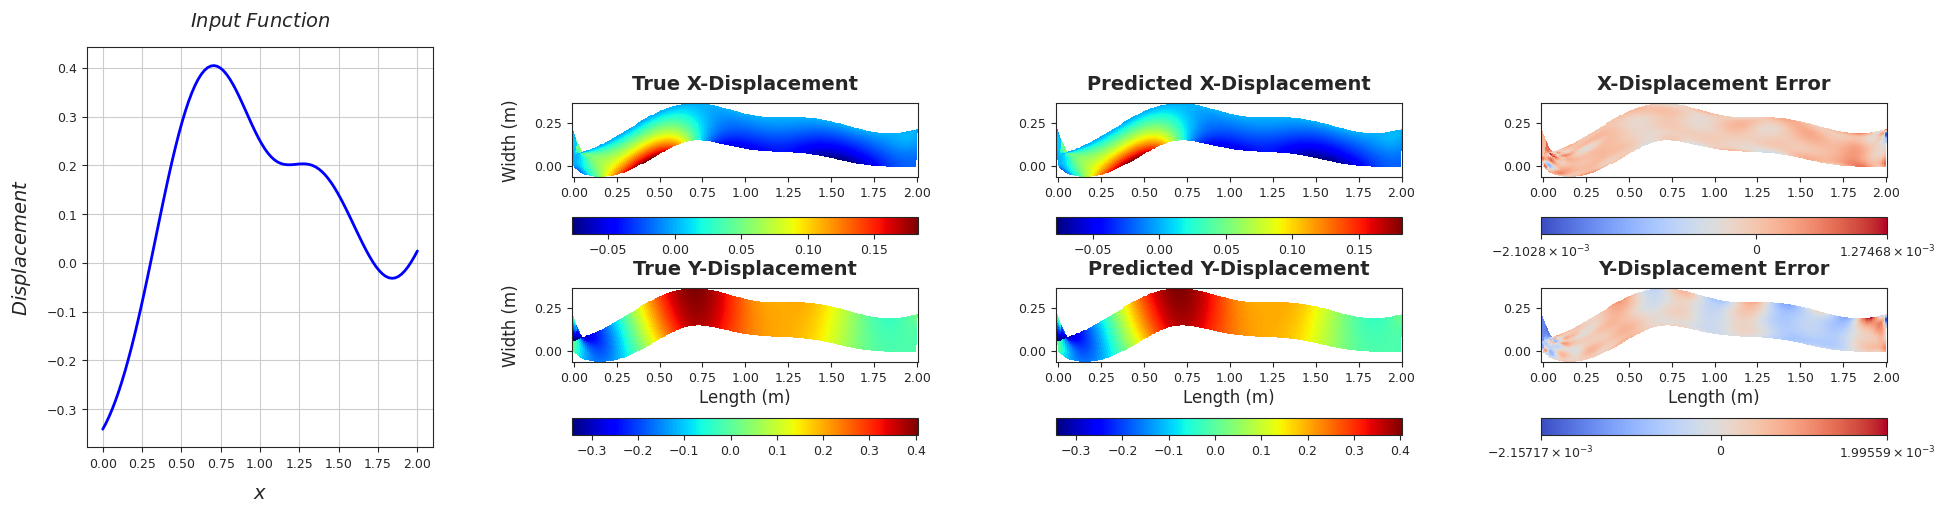

######################################################################################################################################################################################################################################
TEST SAMPLE 90
Rel. L2 Error (X-Displacement) = 0.0048, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0027, R2 score (Y-Displacement) = 1.0


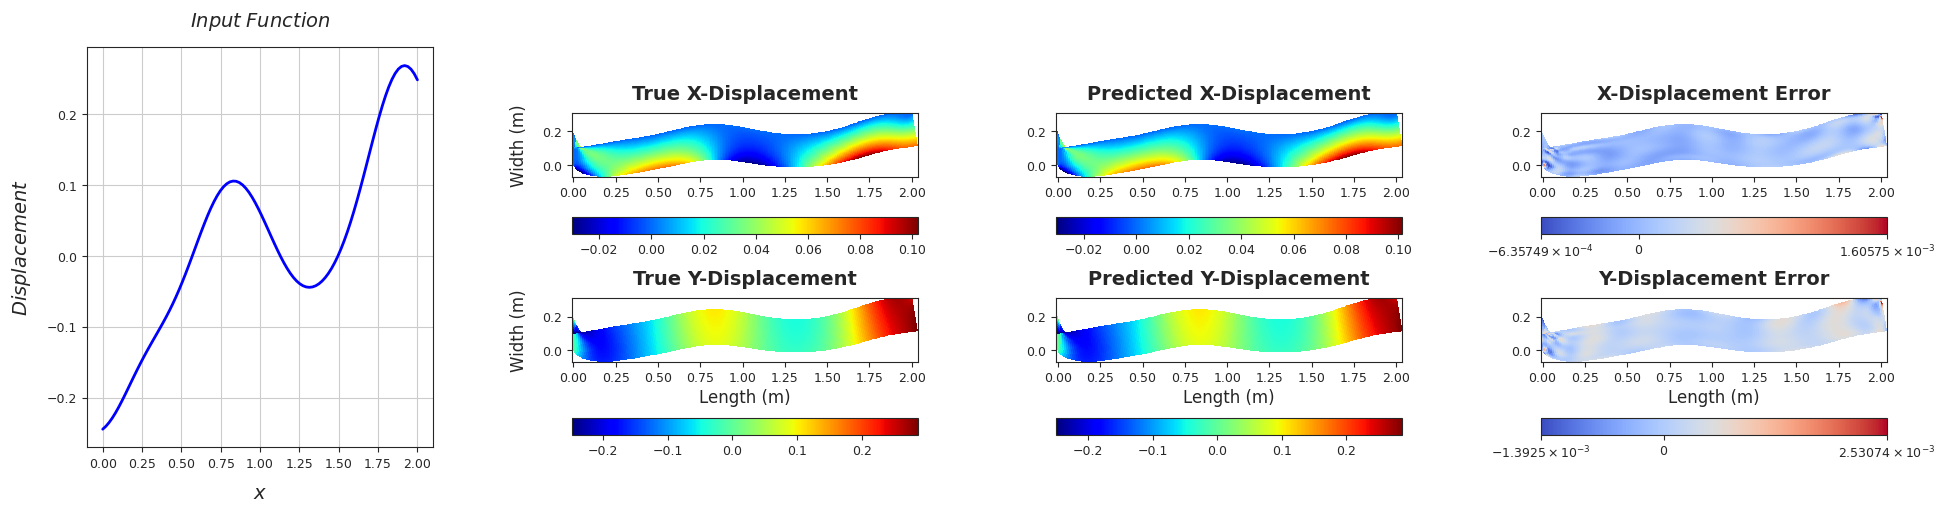

######################################################################################################################################################################################################################################
TEST SAMPLE 100
Rel. L2 Error (X-Displacement) = 0.0059, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0028, R2 score (Y-Displacement) = 1.0


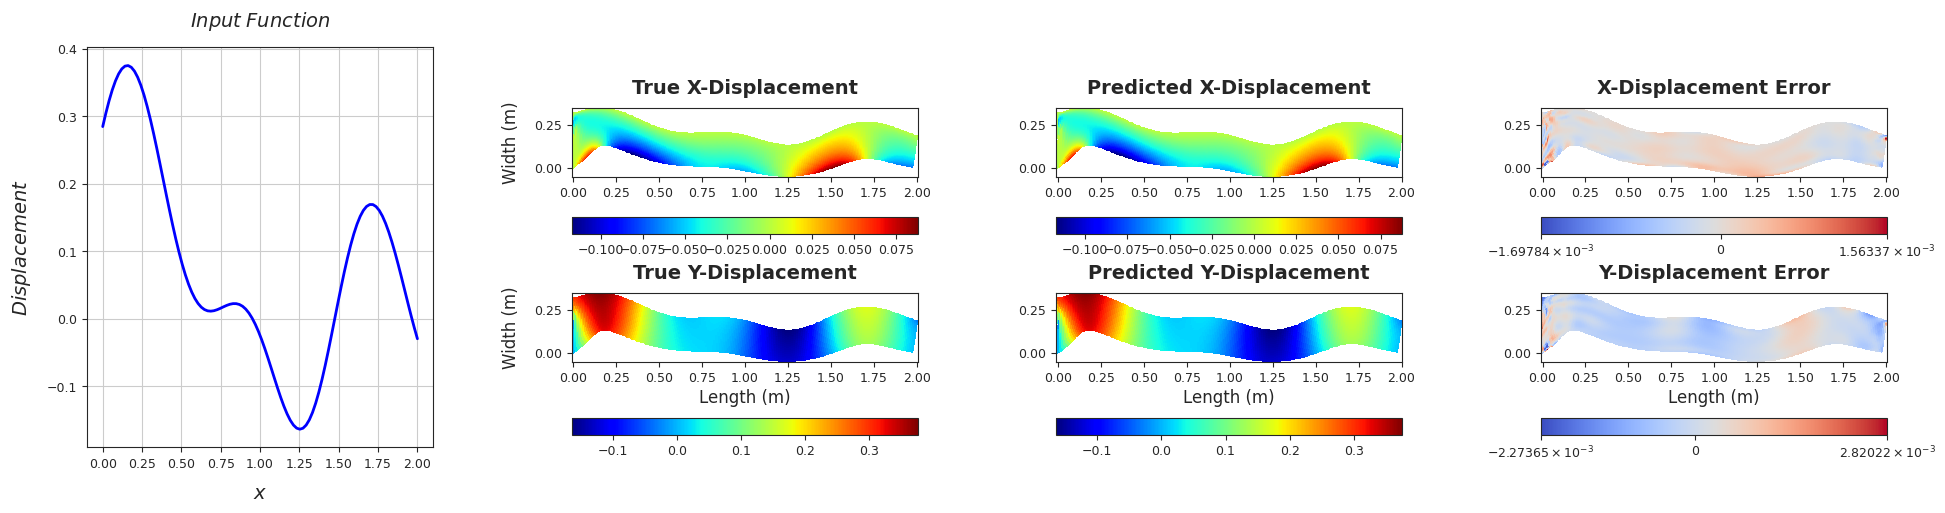

######################################################################################################################################################################################################################################
TEST SAMPLE 110
Rel. L2 Error (X-Displacement) = 0.0036, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0031, R2 score (Y-Displacement) = 1.0


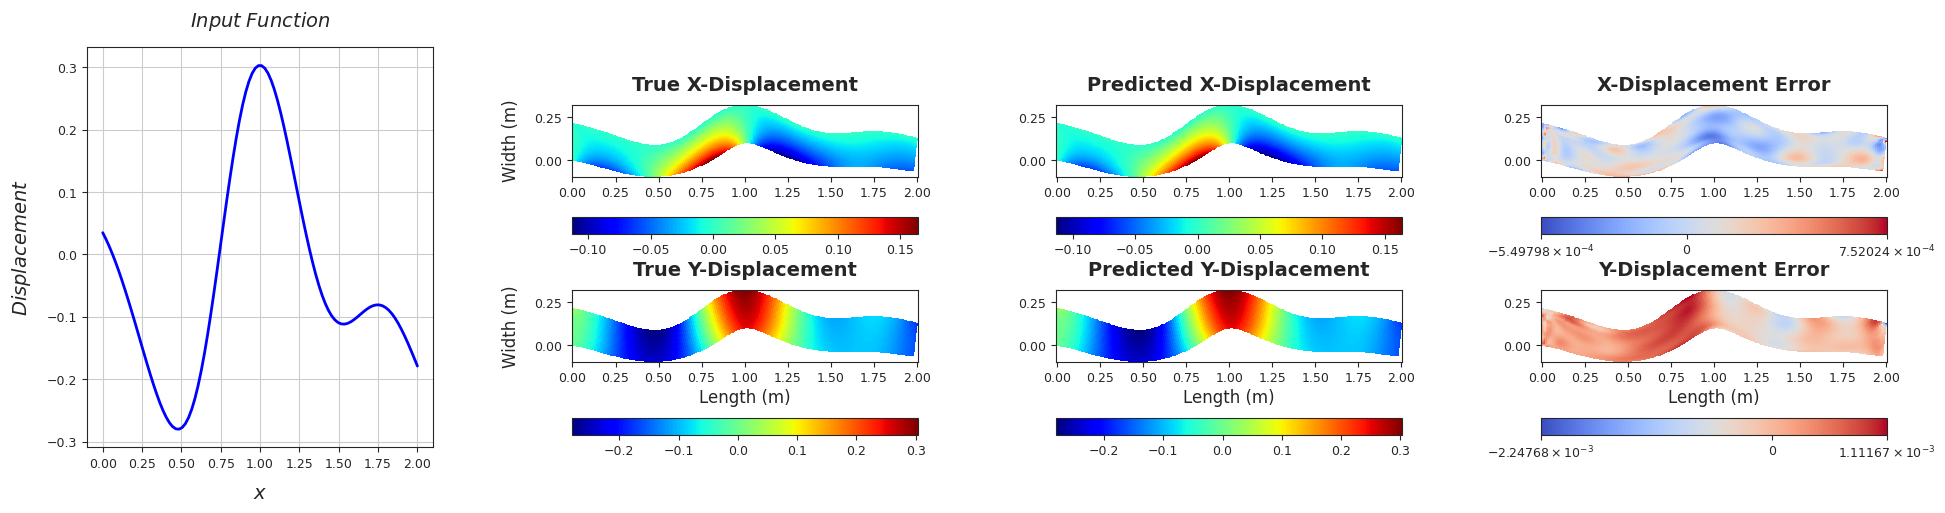

######################################################################################################################################################################################################################################
TEST SAMPLE 120
Rel. L2 Error (X-Displacement) = 0.0091, R2 score (X-Displacement) = 0.9999
Rel. L2 Error (Y-Displacement) = 0.0045, R2 score (Y-Displacement) = 1.0


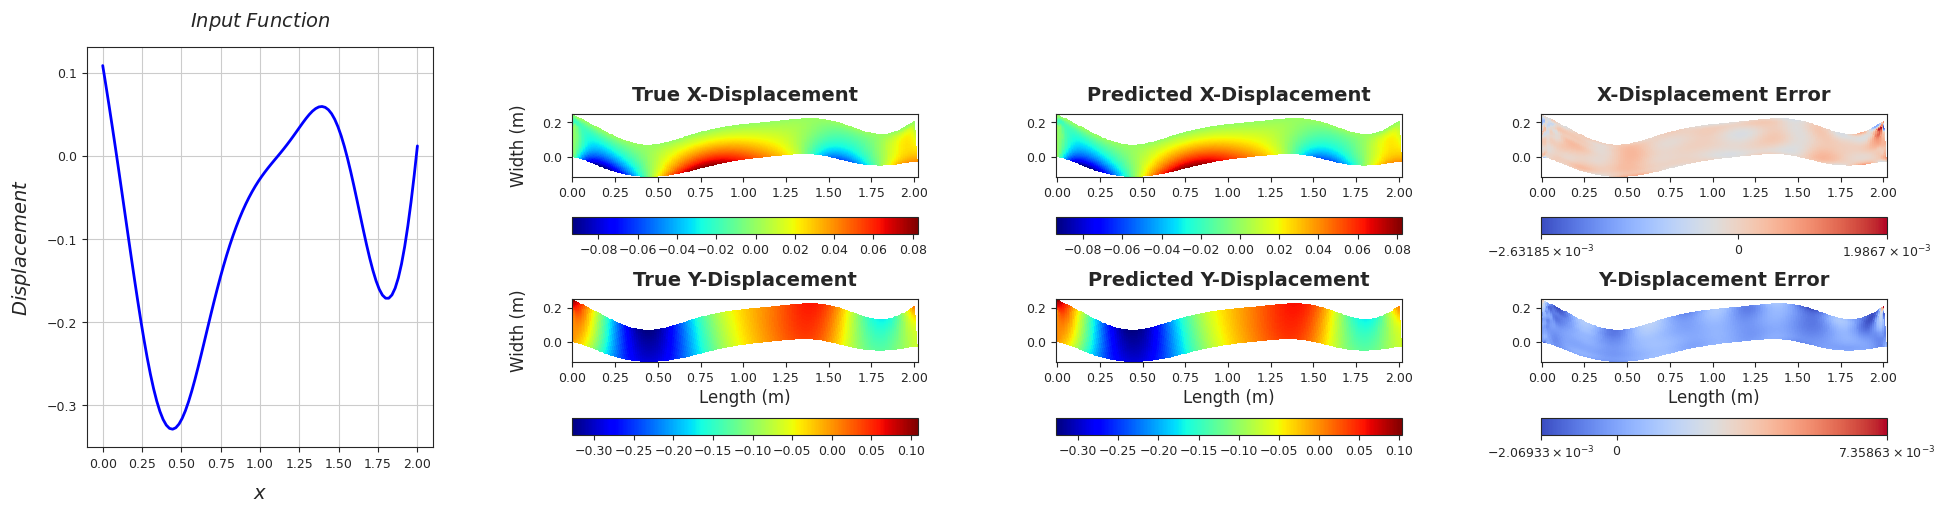

######################################################################################################################################################################################################################################
TEST SAMPLE 130
Rel. L2 Error (X-Displacement) = 0.0057, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0022, R2 score (Y-Displacement) = 1.0


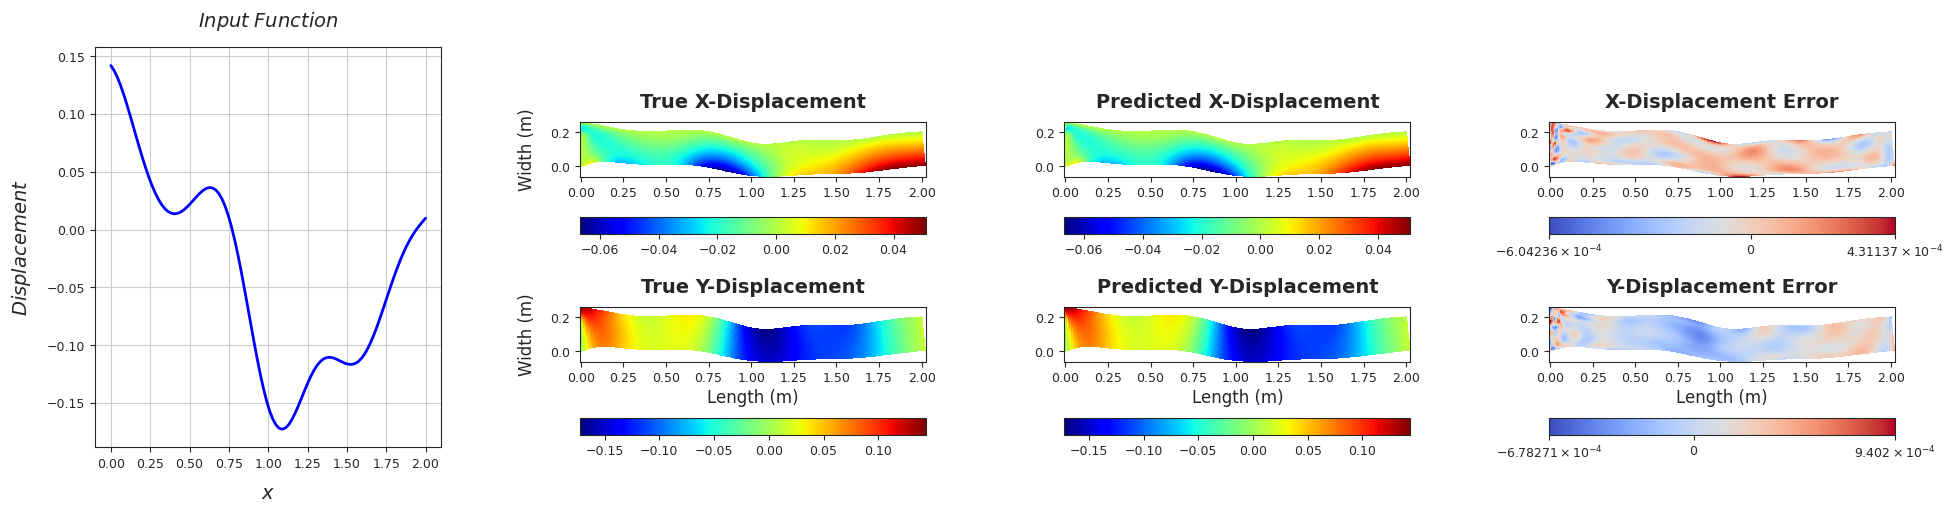

######################################################################################################################################################################################################################################
TEST SAMPLE 140
Rel. L2 Error (X-Displacement) = 0.0041, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0026, R2 score (Y-Displacement) = 1.0


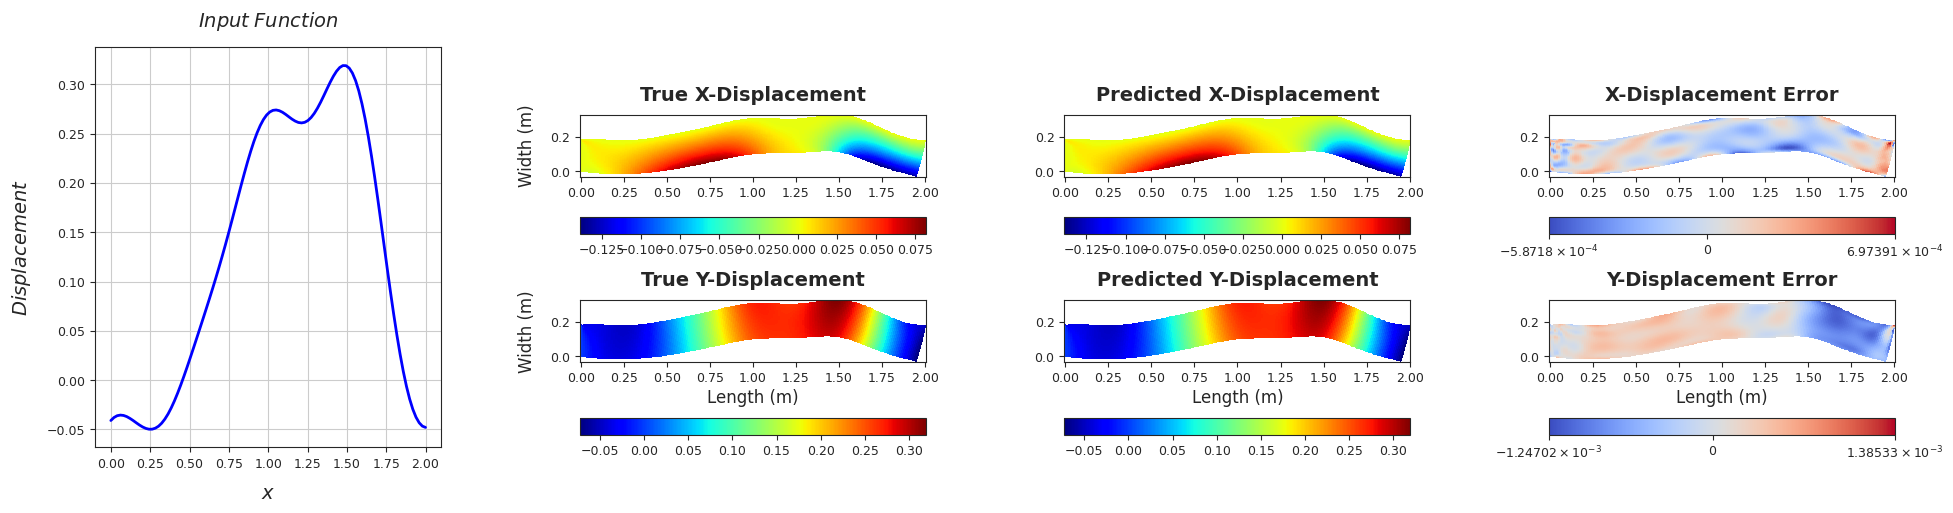

######################################################################################################################################################################################################################################
TEST SAMPLE 150
Rel. L2 Error (X-Displacement) = 0.0106, R2 score (X-Displacement) = 0.9999
Rel. L2 Error (Y-Displacement) = 0.0038, R2 score (Y-Displacement) = 1.0


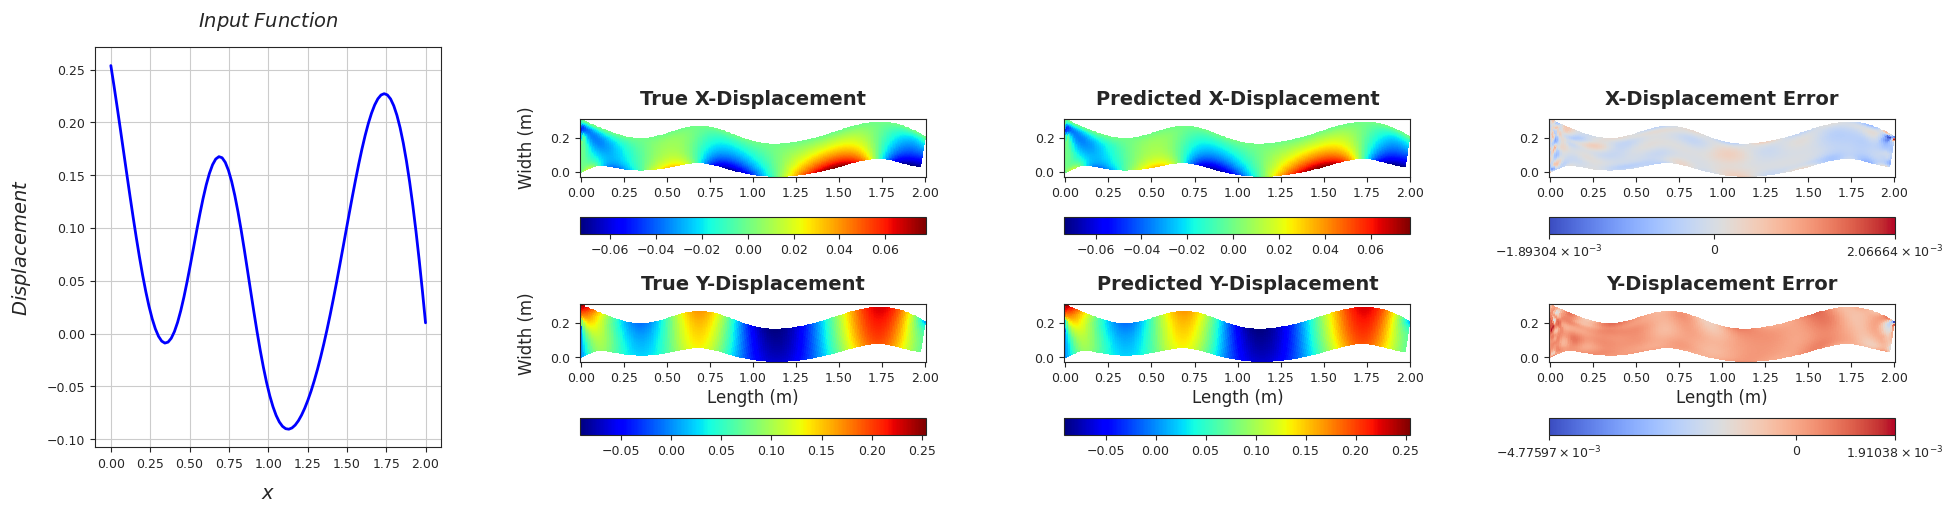

######################################################################################################################################################################################################################################
TEST SAMPLE 160
Rel. L2 Error (X-Displacement) = 0.0049, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0031, R2 score (Y-Displacement) = 1.0


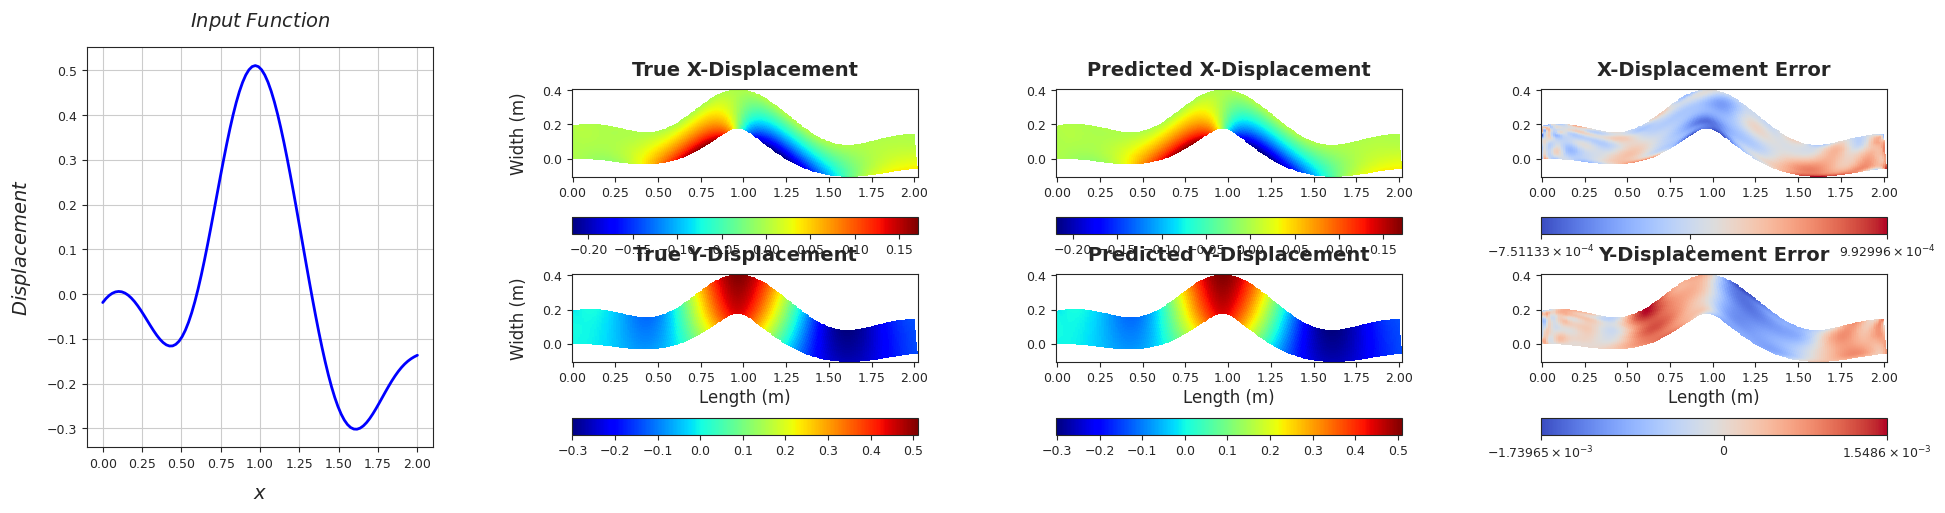

######################################################################################################################################################################################################################################
TEST SAMPLE 170
Rel. L2 Error (X-Displacement) = 0.0077, R2 score (X-Displacement) = 0.9999
Rel. L2 Error (Y-Displacement) = 0.0029, R2 score (Y-Displacement) = 1.0


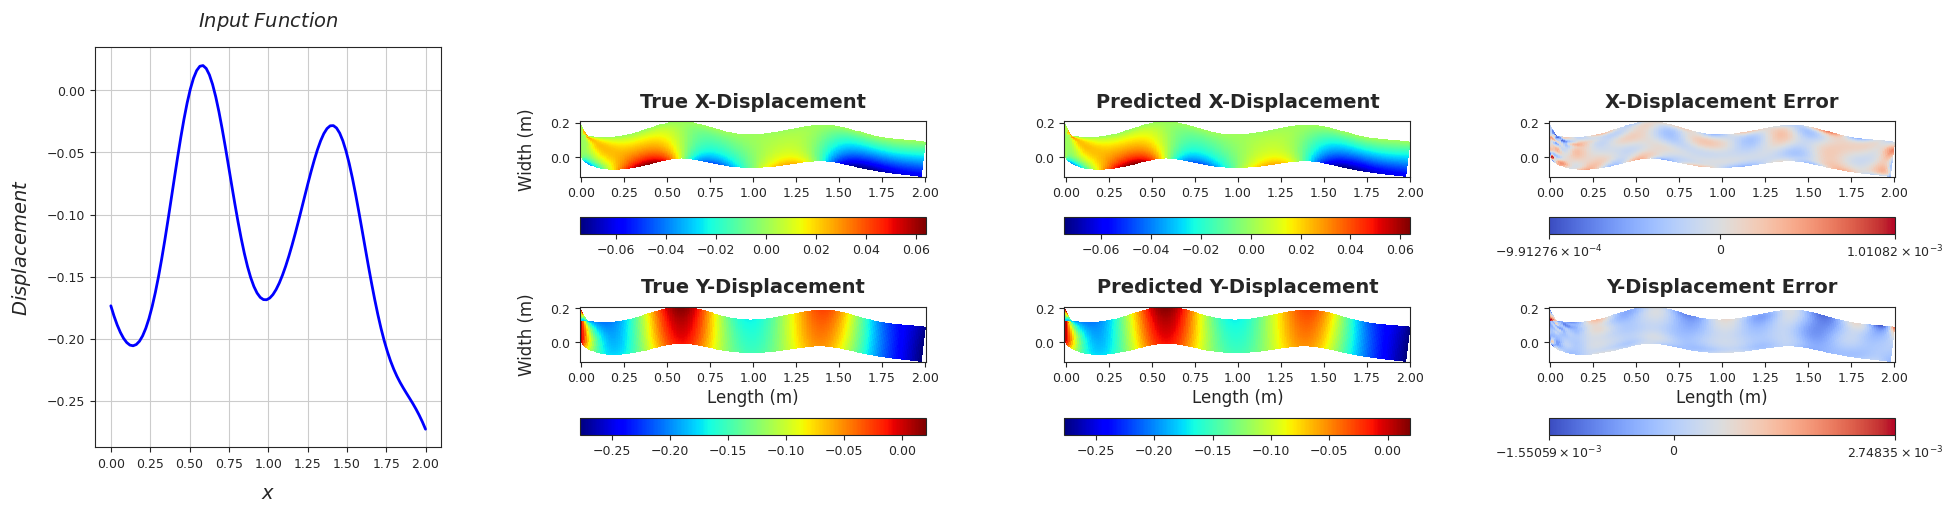

######################################################################################################################################################################################################################################
TEST SAMPLE 180
Rel. L2 Error (X-Displacement) = 0.0038, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0028, R2 score (Y-Displacement) = 1.0


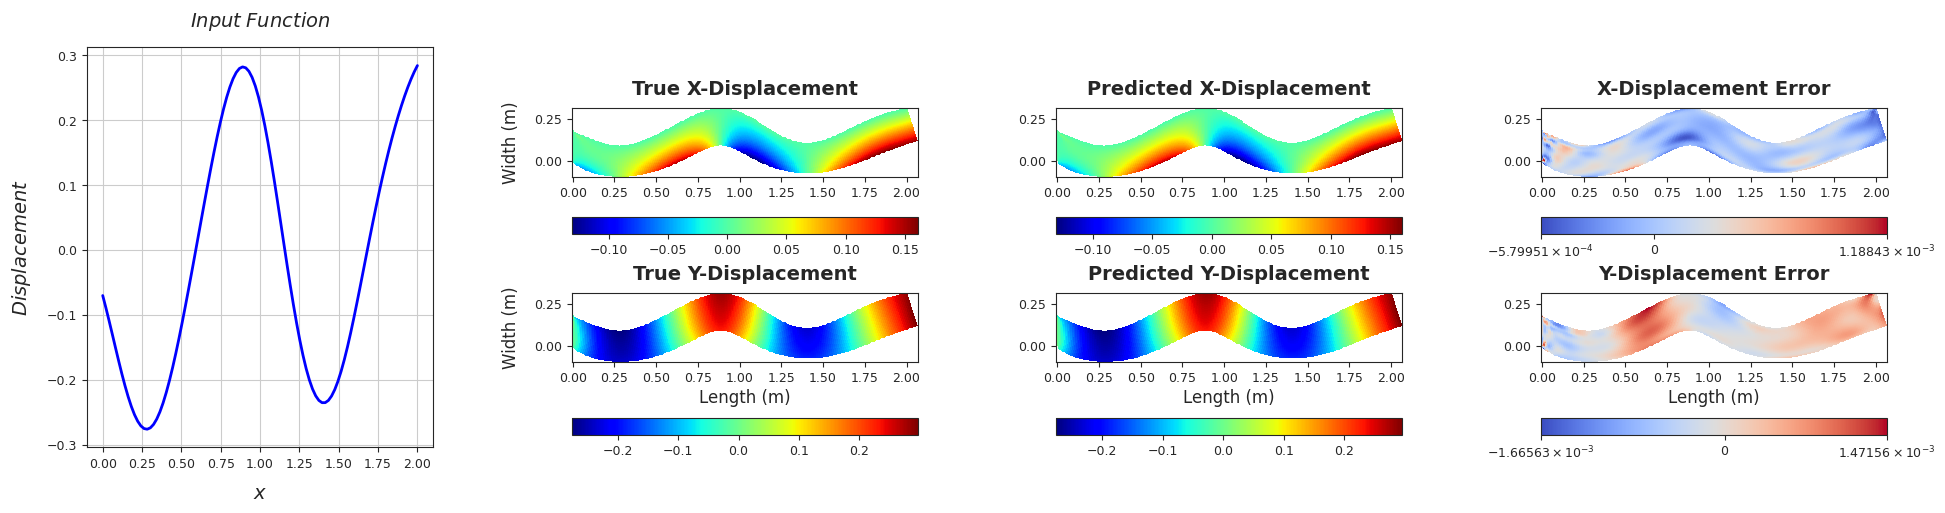

######################################################################################################################################################################################################################################
TEST SAMPLE 190
Rel. L2 Error (X-Displacement) = 0.0055, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0034, R2 score (Y-Displacement) = 1.0


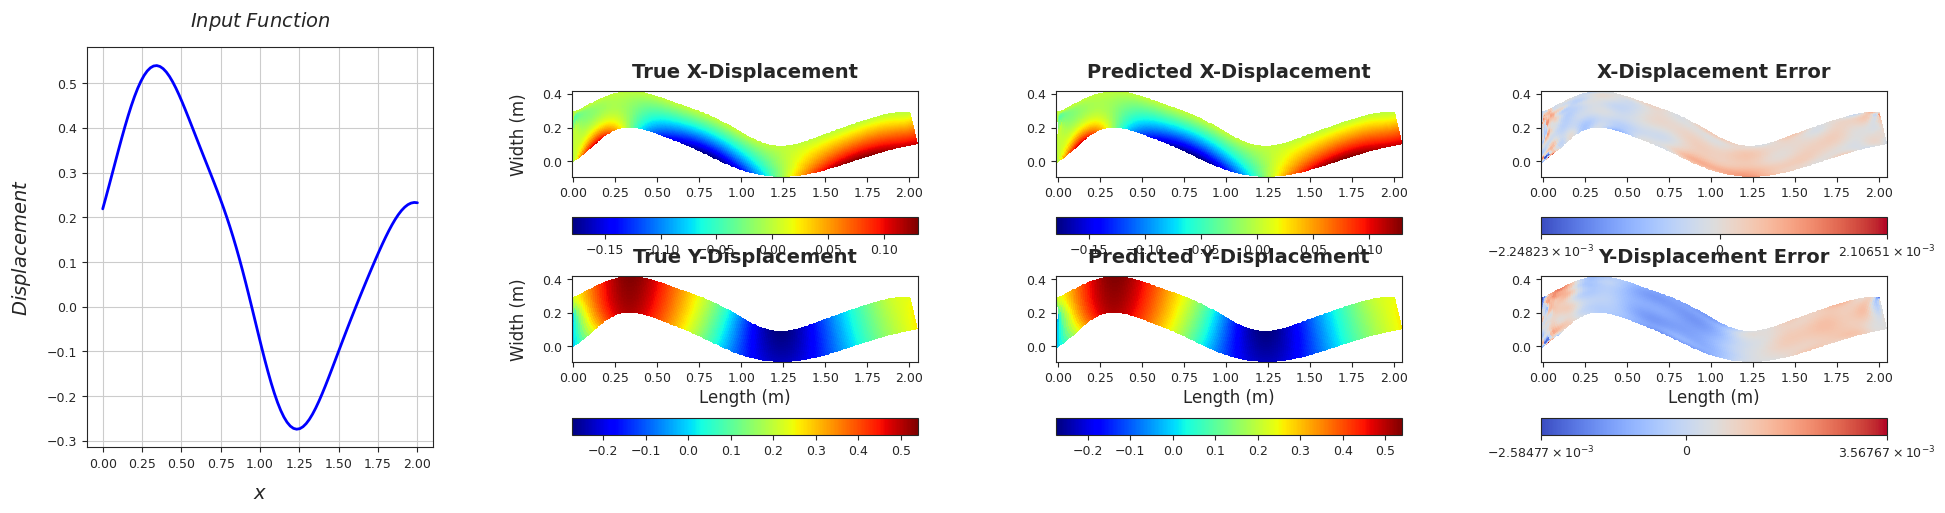

######################################################################################################################################################################################################################################
TEST SAMPLE 200
Rel. L2 Error (X-Displacement) = 0.0043, R2 score (X-Displacement) = 1.0
Rel. L2 Error (Y-Displacement) = 0.0031, R2 score (Y-Displacement) = 1.0


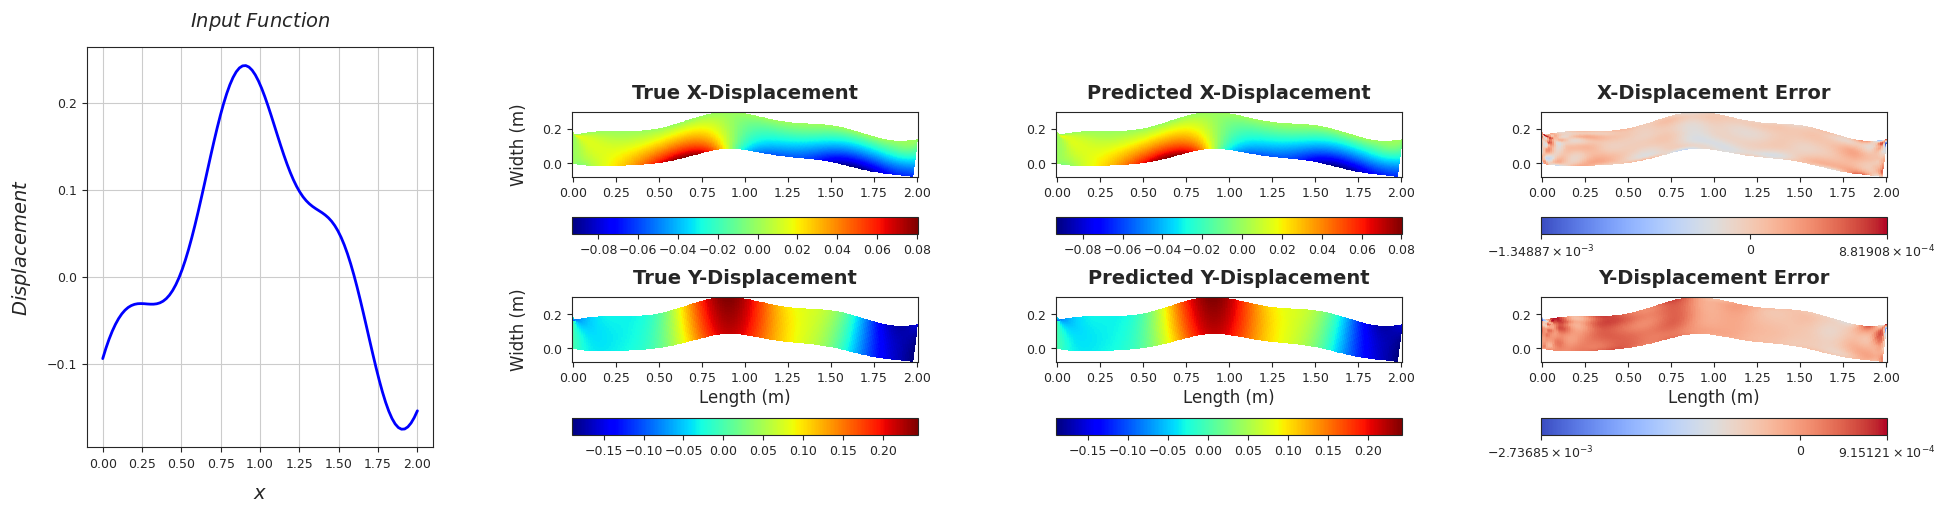

######################################################################################################################################################################################################################################
Mean Squared Error Test (X-Displacement):
 4.613826930288667e-08
Mean Squared Error Test (Y-Displacement):
 2.9578710442734745e-07


In [ ]:
sensor_loc = sensor_loc.T
def interpolate_solution(coordinates, prediction_field, target_field):
    """
    Interpolate scattered solution data onto a regular grid and plot the results.
    
    Args:
        coordinates: Array of shape (1314, 2) containing x,y coordinates of scattered points
        prediction_field: Predicted values at scattered points (1314,)
        target_field: Target values at scattered points (1314,)
        field_type: String indicating field type ("X" or "Y")
        length: Domain length in meters
        width: Domain width in meters
        save: Boolean to save the plot
        resultdir: Directory to save results
        sample_num: Sample number for saving
    """
    # Create fine regular grid for interpolation
    length = 2 # units
    width = 0.2 # units
    nx_fine, ny_fine = 201, 101  # Increased resolution
    x_fine = np.linspace(0, length, nx_fine)
    y_fine = np.linspace(0, width, ny_fine)
    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
    
    # Interpolate prediction and target fields onto regular grid
    prediction_interp = griddata(coordinates, prediction_field, 
                               (X_fine, Y_fine), method='cubic', fill_value=np.nan)
    target_interp = griddata(coordinates, target_field, 
                            (X_fine, Y_fine), method='cubic', fill_value=np.nan)
    
    error_interp = target_interp - prediction_interp
    
    return X_fine, Y_fine, prediction_interp, target_interp, error_interp

for i in range(inputs_test.shape[0]):
    branch_inputs = inputs_test[i].reshape(1, num_sensor)
    trunk_inputs = grid

    prediction_x_i, prediction_y_i = DeepONet(best_params, branch_inputs, trunk_inputs)
    target_x_i = outputs_x_test[i]
    target_y_i = outputs_y_test[i]

    mse_x_i = np.mean((prediction_x_i - target_x_i)**2)
    mse_list_x.append(mse_x_i.item())
    mse_y_i = np.mean((prediction_y_i - target_y_i)**2)
    mse_list_y.append(mse_y_i.item())

    if (i+1) % 10 == 0:
        print(colored('TEST SAMPLE '+str(i+1), 'red'))
        
        # Calculate metrics
        r2score_x = metrics.r2_score(target_x_i.flatten(), prediction_x_i.flatten())
        relerror_x = np.linalg.norm(target_x_i - prediction_x_i) / np.linalg.norm(target_x_i)
        r2score_x = float('%.4f'%r2score_x)
        relerror_x = float('%.4f'%relerror_x)
        r2score_y = metrics.r2_score(target_y_i.flatten(), prediction_y_i.flatten())
        relerror_y = np.linalg.norm(target_y_i - prediction_y_i) / np.linalg.norm(target_y_i)
        r2score_y = float('%.4f'%r2score_y)
        relerror_y = float('%.4f'%relerror_y)
        
        print('Rel. L2 Error (X-Displacement) = '+str(relerror_x)+', R2 score (X-Displacement) = '+str(r2score_x))
        print('Rel. L2 Error (Y-Displacement) = '+str(relerror_y)+', R2 score (Y-Displacement) = '+str(r2score_y))
        
        fig = plt.figure(figsize=(20, 5)) 
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.4, hspace=0.01)

        # Input Function Plot
        ax = fig.add_subplot(2, 4, (1,5))
        plt.plot(sensor_loc, inputs_test[i], color='blue', linewidth=2)
        plt.xlabel(r'$x$', fontsize=14, fontweight='bold', labelpad=10)  
        plt.ylabel(r'$Displacement$', fontsize=14, fontweight='bold', labelpad=10)
        plt.title('$Input\;Function$', fontsize=14, fontweight='bold', pad=15)  
        plt.grid(True)

        # Interpolated Displacement Fields
        X_fine, Y_fine, pred_x_interp, target_x_interp, error_x_interp = interpolate_solution(
            grid, prediction_x_i.flatten(), target_x_i.flatten())
        X_fine, Y_fine, pred_y_interp, target_y_interp, error_y_interp = interpolate_solution(
            grid, prediction_y_i.flatten(), target_y_i.flatten())

        # Scaling factors and interpolations
        scale_factor = 0.4
        target_displacement_resultant = (target_x_interp**2 + target_y_interp**2)**(0.5)
        predicted_displacement_resultant = (pred_x_interp**2 + pred_y_interp**2)**(0.5)
        X_fine_sc = X_fine + scale_factor * target_x_interp
        Y_fine_sc = Y_fine + scale_factor * target_y_interp

        # True X-Displacement
        ax = fig.add_subplot(2, 4, 2)
        im = ax.pcolormesh(X_fine_sc, Y_fine_sc, target_x_interp, shading='auto', cmap='jet')
        ax.set_aspect('equal')
        ax.set_title('True X-Displacement', fontsize=14, fontweight='bold', pad=10)  # Title padding
        ax.set_ylabel('Width (m)', fontsize=12, labelpad=10)
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)

        # Predicted X-Displacement
        ax = fig.add_subplot(2, 4, 3)
        im = ax.pcolormesh(X_fine_sc, Y_fine_sc, pred_x_interp, shading='auto', cmap='jet')
        ax.set_aspect('equal')
        ax.set_title('Predicted X-Displacement', fontsize=14, fontweight='bold', pad=10)
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)

        # X-Displacement Error with SymLogNorm
        ax = fig.add_subplot(2, 4, 4)
        im = ax.pcolormesh(X_fine_sc, Y_fine_sc, error_x_interp, shading='auto', cmap='coolwarm', norm=SymLogNorm(linthresh=0.03))
        ax.set_aspect('equal')
        ax.set_title('X-Displacement Error', fontsize=14, fontweight='bold', pad=10)
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)

        # True Y-Displacement
        ax = fig.add_subplot(2, 4, 6)
        im = ax.pcolormesh(X_fine_sc, Y_fine_sc, target_y_interp, shading='auto', cmap='jet')
        ax.set_aspect('equal')
        ax.set_title('True Y-Displacement', fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Length (m)', fontsize=12, labelpad=3)
        ax.set_ylabel('Width (m)', fontsize=12, labelpad=10)
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.28)

        # Predicted Y-Displacement
        ax = fig.add_subplot(2, 4, 7)
        im = ax.pcolormesh(X_fine_sc, Y_fine_sc, pred_y_interp, shading='auto', cmap='jet')
        ax.set_aspect('equal')
        ax.set_title('Predicted Y-Displacement', fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Length (m)', fontsize=12, labelpad=3)
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.28)

        # Y-Displacement Error with SymLogNorm
        ax = fig.add_subplot(2, 4, 8)
        im = ax.pcolormesh(X_fine_sc, Y_fine_sc, error_y_interp, shading='auto', cmap='coolwarm', norm=SymLogNorm(linthresh=0.03))
        ax.set_aspect('equal')
        ax.set_title('Y-Displacement Error', fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Length (m)', fontsize=12, labelpad=3)
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.28)
                
        if save == True:
            plt.savefig(os.path.join(resultdir,'Test_Sample_'+str(i+1)+'.pdf'))
            plt.show()
            plt.close()
        if save == False:
            plt.show()

        print(colored('#'*230, 'green'))

mse_ef = sum(mse_list_x) / len(mse_list_x)
print("Mean Squared Error Test (X-Displacement):\n", mse_ef)
mse_mech = sum(mse_list_y) / len(mse_list_y)
print("Mean Squared Error Test (Y-Displacement):\n", mse_mech)